In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from beamline34IDC.simulation.facade import Implementors
from beamline34IDC.simulation.facade.focusing_optics_factory import focusing_optics_factory_method
from beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
from beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(1, 10000)
print("Default random seed is", DEFAULT_RANDOM_SEED)

Default random seed is 1323


In [5]:
work_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/work_directory'
os.chdir(work_dir)
input_beam_path = "primary_optics_system_beam.dat"

In [6]:
fig_save_path = 'figures/vkb_3/'

In [7]:
if not os.path.isdir(fig_save_path):
    print("Fig save directory does not exist. Trying to create.")
    os.mkdir(fig_save_path)

In [8]:
move_motors = ['vkb_3']

In [9]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

8.974726544321371e-05 8.974726544321371e-05


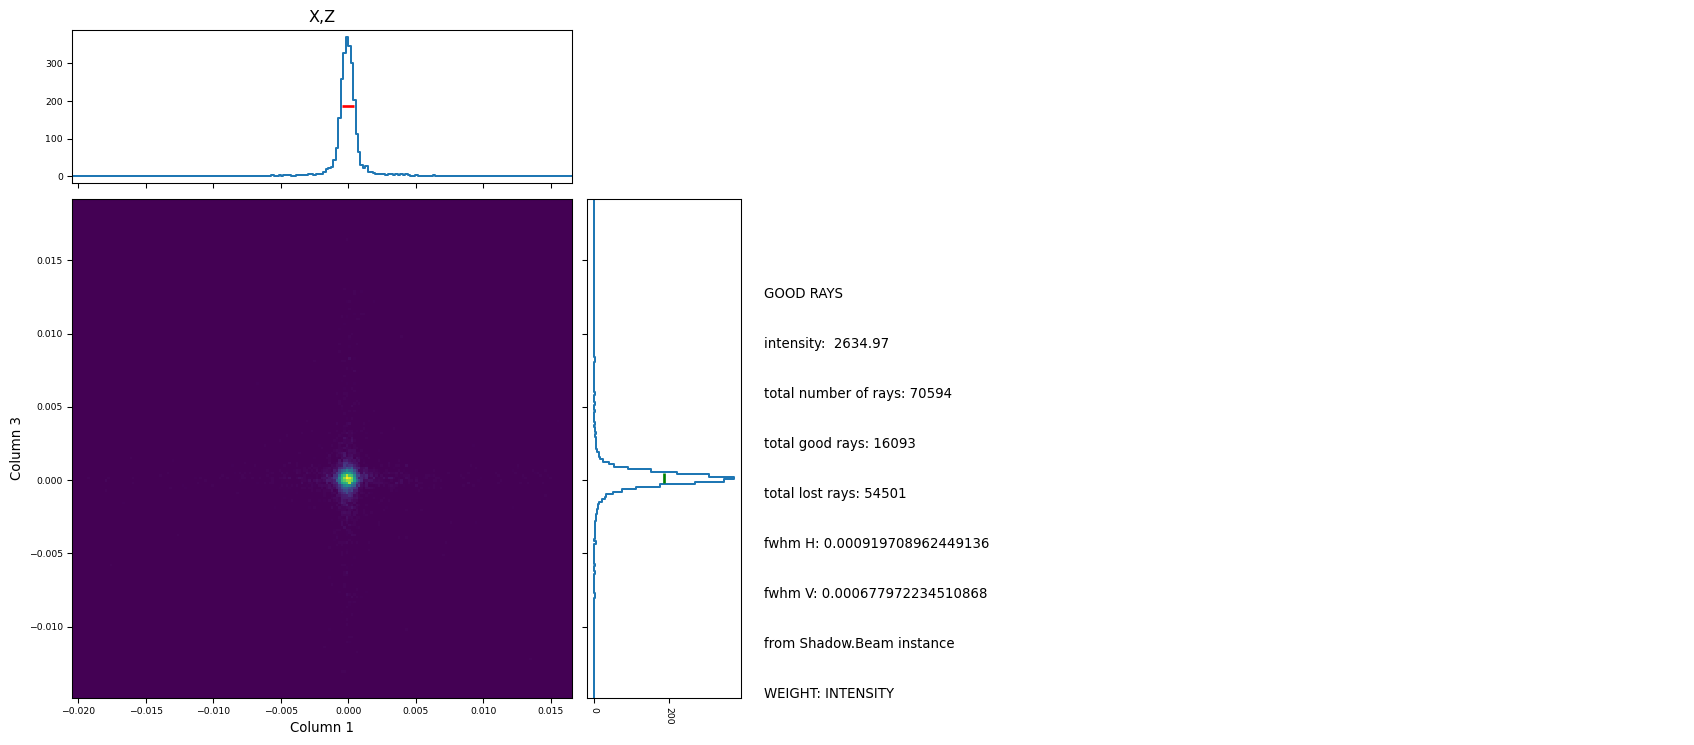

In [10]:
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
focusing_system = movers.move_motors(focusing_system, 'vkb_3', 0.0)
centroid_new, out_beam_new, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

print(centroid, centroid_new)
_ = plot_shadow_beam_spatial_distribution(out_beam_new)

initial value is 3.0000000000000506 initial translation is 11.602569779366487
New value is 14.602569779366538
8.974726544321371e-05 5.058626391005352


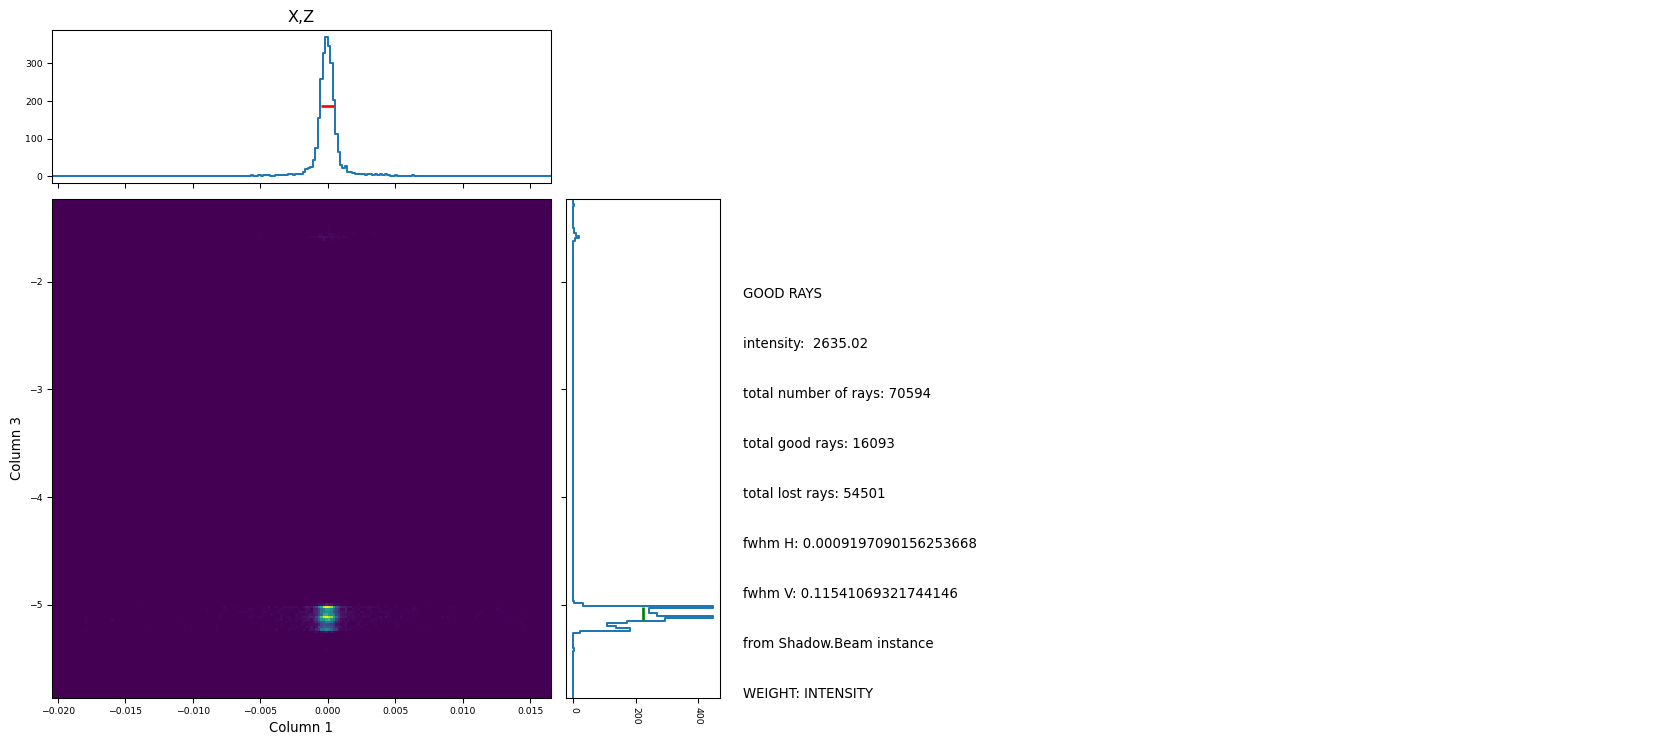

In [11]:
initial_translation = np.random.uniform(-15, 15)
initial_value = focusing_system.get_vkb_motor_3_pitch()
print("initial value is", initial_value, "initial translation is", initial_translation)
movers.move_motors(focusing_system, move_motors, initial_translation, movement='relative')
print("New value is", focusing_system.get_vkb_motor_3_pitch())
centroid_new, out_beam_new, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

print(centroid, centroid_new)
_ = plot_shadow_beam_spatial_distribution(out_beam_new)

In [12]:
initial_absolute_motor_positions = initial_value + initial_translation
initial_absolute_motor_positions, initial_value, initial_translation

(14.602569779366537, 3.0000000000000506, 11.602569779366487)

In [13]:
focusing_system = movers.move_motors(focusing_system, move_motors, initial_absolute_motor_positions,
                                     movement='absolute')
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
print(focusing_system.get_vkb_motor_3_pitch(), centroid)

14.60256977936654 5.058626391005346


In [14]:
dw.__dict__

{'_DictionaryWrapper__dictionary': {'h_sigma': 0.001798264617926611,
  'h_fwhm': 0.0009197090156253668,
  'h_centroid': -2.3901290270918982e-05,
  'v_sigma': 0.4184175218520859,
  'v_fwhm': 0.11541069321744146,
  'v_centroid': -5.058626390948881,
  'integral_intensity': 2635.021767258025,
  'peak_intensity': 59.827653169562396,
  'gaussian_fit': {}}}

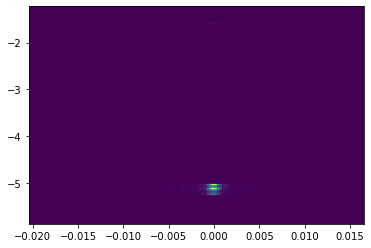

In [15]:
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)

In [16]:
initial_centroids = []
initial_out_beams = []
absolute_positions = []

start_guesses = []
overall_successes = []
final_out_beams = []
final_opt_results = []
final_centroids = []

for outer in tqdm(range(6)):
    translations = np.random.uniform(-15, 15)
    initial_absolute_motor_positions = initial_value + translations
    print("Initial motor position is", initial_absolute_motor_positions)
    absolute_positions.append(initial_absolute_motor_positions)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         initial_absolute_motor_positions, movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                          motor_types=move_motors, 
                                          initial_motor_positions=initial_absolute_motor_positions, 
                                          random_seed=DEFAULT_RANDOM_SEED)
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, guess_min=-1, guess_max=1.)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')
    

  0%|          | 0/6 [00:00<?, ?it/s]

Initial motor position is 5.659117906227963
motors ['vkb_3'] trans [0.] current loss 1.1751524834544278
Initial loss is 1.1751524834544278
motors ['vkb_3'] trans [-0.00792399] current loss 1.1716491184116495
motors ['vkb_3'] trans [-0.00832019] current loss 1.171482754190775
motors ['vkb_3'] trans [-0.00871638] current loss 1.17130072432515
motors ['vkb_3'] trans [-0.00950878] current loss 1.1709473633250604
motors ['vkb_3'] trans [-0.01069738] current loss 1.1704227209546738
motors ['vkb_3'] trans [-0.01307458] current loss 1.1693763849437786
motors ['vkb_3'] trans [-0.01664037] current loss 1.1678060789979496
motors ['vkb_3'] trans [-0.02377196] current loss 1.1646456659156397
motors ['vkb_3'] trans [-0.03446934] current loss 1.1599218435477987
motors ['vkb_3'] trans [-0.0558641] current loss 1.1504674563605526
motors ['vkb_3'] trans [-0.08795625] current loss 1.1362940554407102
motors ['vkb_3'] trans [-0.15214053] current loss 1.107943963953387
motors ['vkb_3'] trans [-0.24841697] c

 17%|█▋        | 1/6 [03:04<15:20, 184.02s/it]

Test 0 success True
Initial motor position is 9.322828901495939
motors ['vkb_3'] trans [0.] current loss 2.7908732252254826
Initial loss is 2.7908732252254826
motors ['vkb_3'] trans [0.02221623] current loss 2.8006359340909617
motors ['vkb_3'] trans [0.02332705] current loss 2.8011316733340283
motors ['vkb_3'] trans [0.02110542] current loss 2.800138558633297
motors ['vkb_3'] trans [0.0188838] current loss 2.7991817530881056
motors ['vkb_3'] trans [0.01555136] current loss 2.7977071987074718
motors ['vkb_3'] trans [0.00888649] current loss 2.79478245466011
motors ['vkb_3'] trans [-0.00111081] current loss 2.790400270114731
motors ['vkb_3'] trans [-0.02110542] current loss 2.7816044443712107
motors ['vkb_3'] trans [-0.05109734] current loss 2.7684078576600206
motors ['vkb_3'] trans [-0.11108117] current loss 2.7420048402019863
motors ['vkb_3'] trans [-0.20105692] current loss 2.7023487796022163
motors ['vkb_3'] trans [-0.38100841] current loss 2.6231120823212515
motors ['vkb_3'] trans [

 33%|███▎      | 2/6 [06:13<12:28, 187.09s/it]

Test 1 success True
Initial motor position is 2.375749764964687
motors ['vkb_3'] trans [0.] current loss 0.27631880650637897
Initial loss is 0.27631880650637897
motors ['vkb_3'] trans [0.01782776] current loss 0.2684421358673114
motors ['vkb_3'] trans [0.01871915] current loss 0.2680401623592362
motors ['vkb_3'] trans [0.01961054] current loss 0.26765141087745226
motors ['vkb_3'] trans [0.02139332] current loss 0.2668641297086648
motors ['vkb_3'] trans [0.02406748] current loss 0.26568134456563425
motors ['vkb_3'] trans [0.02941581] current loss 0.26331457654628077
motors ['vkb_3'] trans [0.0374383] current loss 0.25976230866881145
motors ['vkb_3'] trans [0.05348329] current loss 0.2526632477715324
motors ['vkb_3'] trans [0.07755077] current loss 0.24201549330112707
motors ['vkb_3'] trans [0.12568573] current loss 0.22072371611251304
motors ['vkb_3'] trans [0.19788818] current loss 0.1887732790406755
motors ['vkb_3'] trans [0.34229306] current loss 0.12489818270688904
motors ['vkb_3'] 

 50%|█████     | 3/6 [08:30<08:13, 164.35s/it]

Test 2 success True
Initial motor position is 2.0505151832258095
motors ['vkb_3'] trans [0.] current loss 0.42020773301722086
Initial loss is 0.42020773301722086
motors ['vkb_3'] trans [0.01991407] current loss 0.41139983283159026
motors ['vkb_3'] trans [0.02090978] current loss 0.41096447061497093
motors ['vkb_3'] trans [0.02190548] current loss 0.4105257236634129
motors ['vkb_3'] trans [0.02389689] current loss 0.4096463579289578
motors ['vkb_3'] trans [0.026884] current loss 0.40832794017854657
motors ['vkb_3'] trans [0.03285822] current loss 0.40568023520602947
motors ['vkb_3'] trans [0.04181955] current loss 0.4017171691468951
motors ['vkb_3'] trans [0.05974222] current loss 0.39377800289204556
motors ['vkb_3'] trans [0.08662622] current loss 0.3818927997164279
motors ['vkb_3'] trans [0.14039422] current loss 0.3581060833092704
motors ['vkb_3'] trans [0.22104621] current loss 0.32242914105735154
motors ['vkb_3'] trans [0.38235021] current loss 0.2510552866028664
motors ['vkb_3'] t

 67%|██████▋   | 4/6 [10:58<05:16, 158.01s/it]

Test 3 success True
Initial motor position is 1.607270833654261
motors ['vkb_3'] trans [0.] current loss 0.6163351982918547
Initial loss is 0.6163351982918547
motors ['vkb_3'] trans [-0.02196401] current loss 0.6260522503422793
motors ['vkb_3'] trans [-0.02306222] current loss 0.626540870858174
motors ['vkb_3'] trans [-0.02086581] current loss 0.625571469216703
motors ['vkb_3'] trans [-0.01866941] current loss 0.6245931813586899
motors ['vkb_3'] trans [-0.01537481] current loss 0.6231391715220143
motors ['vkb_3'] trans [-0.00878561] current loss 0.6202303937102994
motors ['vkb_3'] trans [0.0010982] current loss 0.6158448534687186
motors ['vkb_3'] trans [0.02086581] current loss 0.6071045429152115
motors ['vkb_3'] trans [0.05051723] current loss 0.5939840814427306
motors ['vkb_3'] trans [0.10982007] current loss 0.5677413157115756
motors ['vkb_3'] trans [0.19877433] current loss 0.5283721055287737
motors ['vkb_3'] trans [0.37668285] current loss 0.4496617176009886
motors ['vkb_3'] trans

 83%|████████▎ | 5/6 [13:20<02:32, 152.24s/it]

Test 4 success True
Initial motor position is 5.2323295111779595
motors ['vkb_3'] trans [0.] current loss 0.9865976374936645
Initial loss is 0.9865976374936645
motors ['vkb_3'] trans [-0.04356206] current loss 0.9673544034022462
motors ['vkb_3'] trans [-0.04574016] current loss 0.966392743846422
motors ['vkb_3'] trans [-0.04791826] current loss 0.9654300441308898
motors ['vkb_3'] trans [-0.05227447] current loss 0.9635040722713053
motors ['vkb_3'] trans [-0.05880878] current loss 0.960616894893136
motors ['vkb_3'] trans [-0.07187739] current loss 0.9548382092261722
motors ['vkb_3'] trans [-0.09148032] current loss 0.9461740964142697
motors ['vkb_3'] trans [-0.13068617] current loss 0.9288459961499426
motors ['vkb_3'] trans [-0.18949495] current loss 0.9028650871262989
motors ['vkb_3'] trans [-0.3071125] current loss 0.850887885811817
motors ['vkb_3'] trans [-0.48353883] current loss 0.7729215293613991
motors ['vkb_3'] trans [-0.83639149] current loss 0.616974951348758
motors ['vkb_3'] 

100%|██████████| 6/6 [15:55<00:00, 159.21s/it]

Test 5 success True


In [17]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [18]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [19]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [20]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

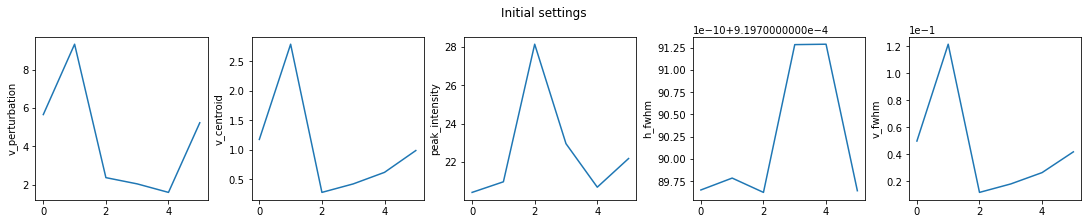

In [29]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_positions)
axes[0].set_ylabel('v_perturbation')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/vkb_3_initial_metrics.png', bbox_inches='tight')

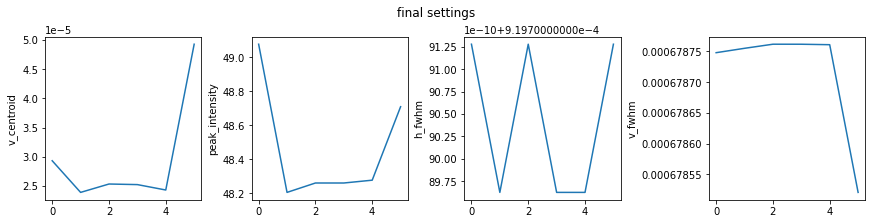

In [28]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/vkb_3_final_metrics.png', bbox_inches='tight')

In [27]:
absolute_positions

[5.659117906227963,
 9.322828901495939,
 2.375749764964687,
 2.0505151832258095,
 1.607270833654261,
 5.2323295111779595]

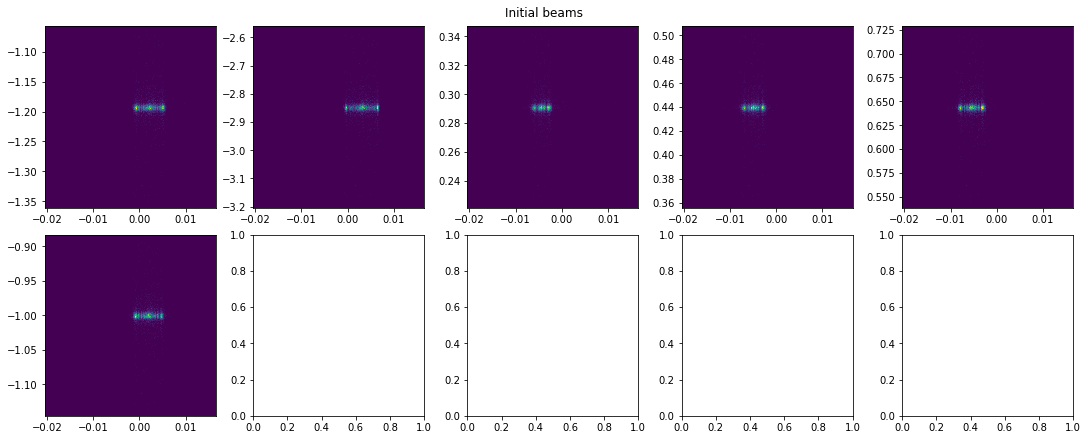

In [25]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/vkb_3_initial_beams.png', bbox_inches='tight')

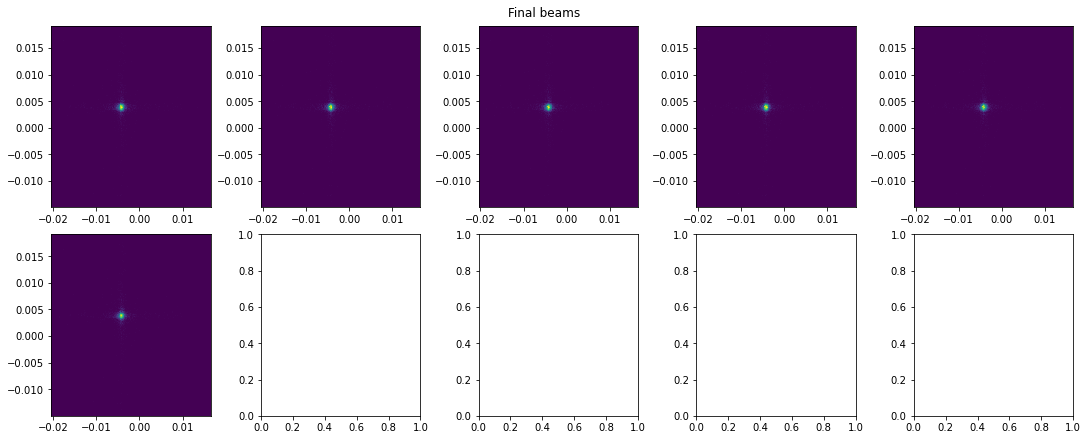

In [26]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/vkb_3_final_beams.png', bbox_inches='tight')

In [30]:
clean_up()